# ICCD Image Saliency Maps

#### Sumner B. Harris

This notebook is designed to calculate the saliency maps from (2+1)D CNN model using ICCD features only to predict the growth kinetics parameters s$_0$, s$_1$ and J. We are using the input gradient method which uses backpropagation to calculate saliency maps for each output dimension of a neural network. By backpropagating gradients from the model's predictions with respect to the input, the saliency maps highlight which input pixels are correlated to the model's outputs. We calculate the saliency map for each of the 3 ouputs.

# Define the ICCD only (2+1)D CNN model

In [1]:
import torch
import torch.nn as nn

class ICCDNet(nn.Module):
    def __init__(self,l1=64,l2=32):
        super(ICCDNet, self).__init__()
        # ICCD imaging feature inputs, the full image size is BATCH,C,frames,H,W where it is N,50,40,40
        self.ICCD_features_ = nn.Sequential(
            #Spatial convolution
            nn.Conv3d(1,64, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(64),
            #Temportal convolution
            nn.Conv3d(64,64,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            #Spatial convolution
            nn.Conv3d(64,128, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(128),
            #Temportal convolution
            nn.Conv3d(128,128,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            #Spatial convolution
            nn.Conv3d(128,256, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            nn.BatchNorm3d(256),
            #Temportal convolution
            nn.Conv3d(256,256,kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(inplace=True),

            #Downsample
            nn.AvgPool3d(kernel_size=(2,2,2),stride=(2,2,2)),

            nn.Flatten(start_dim=1),
            nn.Linear(256*6*5*5,l1),
            nn.LeakyReLU(inplace=True),
            nn.Linear(l1,l2),
            nn.LeakyReLU(inplace=True),
            nn.Linear(l2,3)
        )

    def forward(self,x1):
        #ICCD features
        x1=self.ICCD_features_(x1)
        return x1

# Define function to compute the saliency maps

In [2]:
from torch.autograd import Variable

def compute_saliency_maps_input_gradient(model, input_image):
    # Set the model to evaluation mode
    model.eval()

    # Wrap the input tensor with Variable and set requires_grad to True
    input_variable = Variable(input_image, requires_grad=True)

    # Forward pass
    output = model(input_variable)

    # Initialize a list to store saliency maps for each output dimension
    saliency_maps = []

    # Compute saliency map for each output dimension
    for i in range(output.size(1)):
        # Zero out the gradients
        model.zero_grad()

        # Calculate gradients of the ith output dimension with respect to the input
        output[:, i].backward(retain_graph=True)

        # Get the gradients
        gradients = input_variable.grad.data
        saliency_map = (input_variable.data * gradients).max(dim=1)[0].squeeze()
        
        #Normalize from -1,1 for consistency during comparison
        saliency_map = (saliency_map - saliency_map.min())/(saliency_map.max()-saliency_map.min())*2-1
        saliency_maps.append(saliency_map)

    return saliency_maps

In [3]:
# load the data
# Import our custom helper module
import ICCDutils

datafile = 'PLD data.json'

df = ICCDutils.load_df(datafile)

In [4]:
# Select a sample from the data
idx = 42

# Pull the image
image = torch.tensor(df.loc[idx,'ICCD'],dtype=torch.float32)

checkpoint='ICCDNet_l1-64.0000_l2-32.0000_lr-0.0014_L2-0.0005.model'
weights = torch.load(checkpoint)
model = ICCDNet()
model.eval()

GI_saliency_map = compute_saliency_maps_input_gradient(model, image.unsqueeze(0))

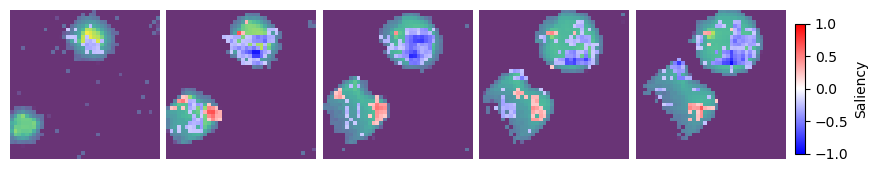

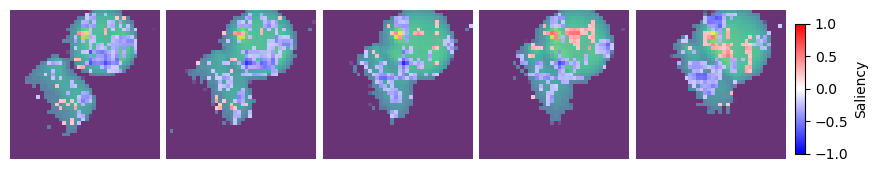

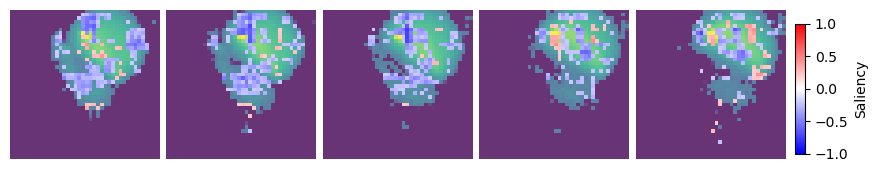

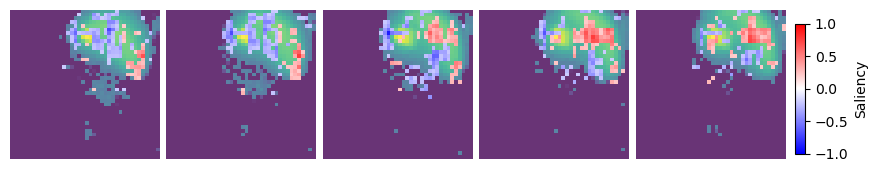

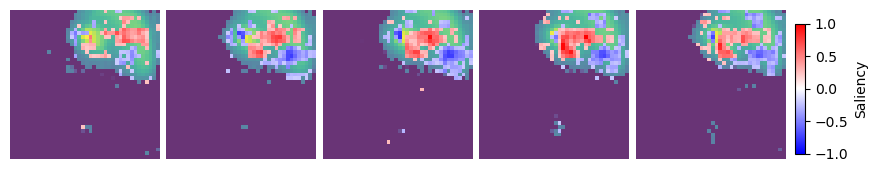

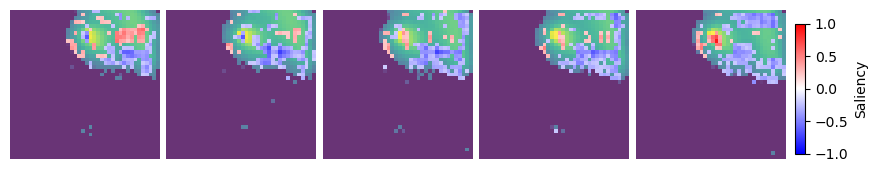

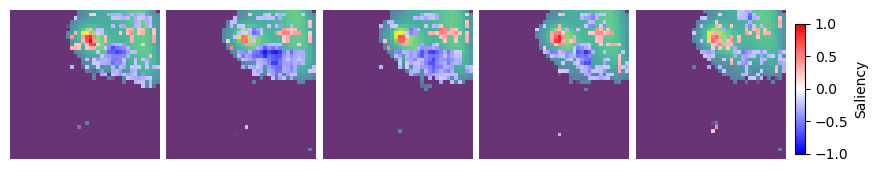

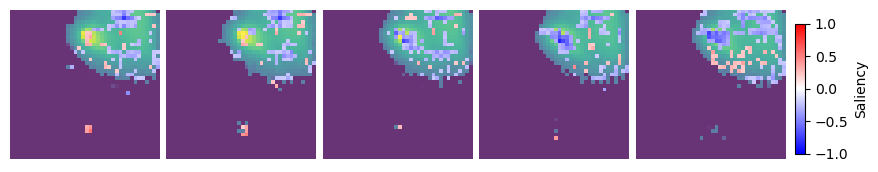

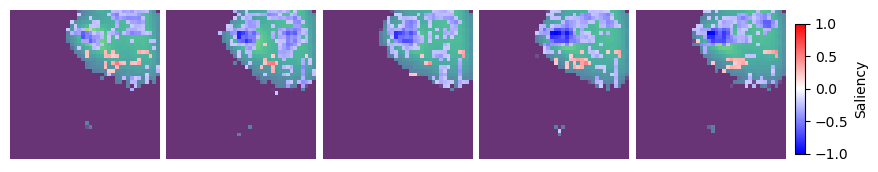

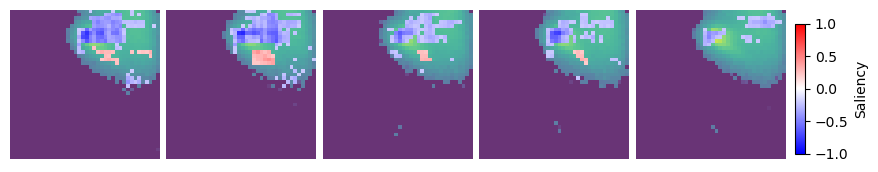

In [5]:
# Set the index to 0, 1, or 2 visualize the saliency map for s0, s1, and J, repsectively
import matplotlib.pyplot as plt
import numpy as np

index = 0

vmax = GI_saliency_map[index].max()
vmin = GI_saliency_map[index].min()

# Define the transparency range
transparency_min = vmin * 0.2
transparency_max = vmax * 0.2

for i in range(10):
    fig, ax = plt.subplots(1, 5, figsize=(10,2))
    for j in range(5):
        ax[j].imshow(image[0, i * 5 + j],alpha=0.8)
        saliency_frame = GI_saliency_map[index][i * 5 + j]

        # Set alpha based on the transparency range
        alpha = np.zeros_like(saliency_frame)
        alpha[(saliency_frame > transparency_max) | (saliency_frame < transparency_min)] = 1

        im = ax[j].imshow(saliency_frame, cmap='bwr', vmin=vmin, vmax=vmax, alpha=alpha)
        ax[j].axis('off')
        
    plt.subplots_adjust(wspace=0.05)
    cax = fig.add_axes([0.91,0.15,0.01,0.65])
    cbar = plt.colorbar(im,cax=cax)
    # Add colorbar to the last subplot
    cbar.set_label('Saliency')
    #plt.tight_layout()
    plt.show()